# Baseline 2:

Staged Least Squares Instrumental Variables Regression using Cornelia's Medical Data

- Using instrumental variables and fixed effects shown here: https://docs.google.com/spreadsheets/d/1_MMYeQuxiov2OLE5AX0CE9R1T1mBrk7vpozy2fGjNBg/edit?usp=sharing
- Include control diagnoses.

---
### Step 1: Import packages

In [1]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS
from statsmodels.stats.anova import anova_lm

import patsy
import sklearn.preprocessing as sklp
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

---
### Step 2: Define working directories and global variables

#### Hi Cornelia! Please have the following directories created ahead of time (data/ and output/ are your original ones; the remaining folders will be used to store the model outputs and relevant metadata we need to associate models to our instrument-and-FEs combinations). Thank you!
* data/
* output/
* models_s1/
* models_s2/
* fixed_effects/

#### 2.1. Set working directories

In [2]:
in_dir_sc = 'C:/Users/cilin/Research/CA_hospitals_capstone/data/'
in_dir_h = 'C:/Users/cilin/Research/CA_hospitals_capstone/output/'
# folder containing stage 1 outputs
out_dir1 = 'C:/Users/cilin/Research/CA_hospitals_capstone/models_s1/'
# folder containing stage 2 outputs
out_dir2 = 'C:/Users/cilin/Research/CA_hospitals_capstone/models_s2/'
# folder containing csvs documenting which fixed effects are in which csv files
out_dir3 = 'C:/Users/cilin/Research/CA_hospitals_capstone/fixed_effects/'



# #Michelle testing on her computer
# in_dir_sc = '/Users/michelle/MIDS/210 Capstone/data/'
# in_dir_h = '/Users/michelle/MIDS/210 Capstone/output/'

# # folder containing stage 1 outputs
# out_dir1 = '/Users/michelle/MIDS/210 Capstone/models_s1/'

# # folder containing stage 2 outputs
# out_dir2 = '/Users/michelle/MIDS/210 Capstone/models_s2/'

# # folder containing csvs documenting which fixed effects are in which csv files
# out_dir3 = '/Users/michelle/MIDS/210 Capstone/fixed_effects/'

#### 2.2. Set Instrumental Variable (predictor), Fixed Effects set, and Notebook Index
* Set the instrumental variable (predictor), fixed effects set, and unique notebook index (please don't change)

In [3]:
# set instrumental variable version
#predictor = 'Izmy_v3_normed_D_and_TPY'
predictor = 'Izmy_v4_nodist_normed_TPY'
#predictor = 'Izmy_v5_all_normed_but_wspd_ratio'
#predictor = 'Izmy_v7_all_normed_no_wspd'

# set FE to one of 8 sets (int)
FE_set_num = 2

# sets unique notebooks index (string - this is just to output a csv file name)
notebook_index = "diff06_no_outliers_fn_F"

# set option to filter outliers on medical outcomes data
filter_medical_outliers = True

#### 2.3. Specify which inputs and outputs we're looking at
* Specify the pm2.5 (target) name 
* Specify instrument (predictor) name
* Specify lead and lag times

In [4]:
lead_time = 9
lag_time = '3'
lag_style = 'fwd'

# define lead time for IV: 'last_month', 'r6', 'r9', 'r12'
IV_lead = "r" + str(lead_time)
HO_lag = lag_style + str(lag_time)

if IV_lead:
    IV_lead_input = "_" + IV_lead 
else:
    # don't add underscore if empty string
    IV_lead_input = IV_lead

# define lag time for Health Outcome: '', 'fwd3', 'cent3', 'fwd6', 'cent6', 'fwd12', 'cent12'
if HO_lag:
    HO_lag_input = "_" + HO_lag
else:
    # don't add underscore if empty string
    HO_lag_input = HO_lag

# IV options: 1 month, 6 months, 9 months, 12 months
IV_window_col = [f'pm25{IV_lead_input}']

# health outcome options (fwd or cent): 1 month, 3 months, 6 months, 12 months
health_outcome_window_col = [f'y_injuries{HO_lag_input}']

filter_cols = IV_window_col + health_outcome_window_col # columns to filter out at the beginning and end of df, before modeling

target_name_s1 = f'pm25{IV_lead_input}'
predictor_name_s1 = f'{predictor}{IV_lead_input}'

print(f"Stage 1\nTarget Name (target_name_s1) = {target_name_s1}\nPredictor Name (predictor_name_s1) = {predictor_name_s1}")
print(f"\nStage 2\nHealth Outcome Lag Input (HO_lag_input) = {HO_lag_input}")

Stage 1
Target Name (target_name_s1) = pm25_r9
Predictor Name (predictor_name_s1) = Izmy_v4_nodist_normed_TPY_r9

Stage 2
Health Outcome Lag Input (HO_lag_input) = _fwd3


#### 2.4. Define fixed effects
* Define Fixed Effects based on the fixed effects set hardcoded in 2.2.

In [5]:
basics = " ~ county + month + year_trend * C(county_month)"
env = '+ avg_temp' + IV_lead_input + ' + avg_elevation_diff_m'

if FE_set_num == 1:
    # FE Set 1
    adds = ""
elif FE_set_num == 2:
    # FE Set 2
    adds = ' + ca_agi_per_returns + total_population'
elif FE_set_num == 3:
    # FE Set 3
    adds = ' + school_count + total_population'
elif FE_set_num == 4:
    # FE Set 4
    adds = ' + total_population + avg_count_ps_within_5km'
elif FE_set_num == 5:
    # FE Set 5
    adds = ' + ca_agi_per_returns'
elif FE_set_num == 6:
    # FE Set 6
    adds = ' + total_population'
elif FE_set_num == 7:
    # FE Set 7
    adds = ' + ca_agi_per_returns + total_population + avg_wspd_top_15_r' + str(lead_time)
elif FE_set_num == 8:
    # FE Set 8
    adds = ''
    env = ''

fixed_effects = basics + env + adds

print("basics:\n{}\n".format(basics))
print("env:\n{}\n".format(env))

print("Fixed effects are:\n{}".format(fixed_effects))

basics:
 ~ county + month + year_trend * C(county_month)

env:
+ avg_temp_r9 + avg_elevation_diff_m

Fixed effects are:
 ~ county + month + year_trend * C(county_month)+ avg_temp_r9 + avg_elevation_diff_m + ca_agi_per_returns + total_population


---
### Step 3: Define functions

In [6]:
def fit_ols(df, outcome, predictor, fixed_effects):
    ''''''
    # drop if outcome is nan
    temp = df[~df[outcome].isna()]
    temp.reset_index(drop=True, inplace=True)

    # create FE and interactions between FE and continous vars
    f = outcome + fixed_effects
    y, X_fe = patsy.dmatrices(f, temp, return_type="dataframe")
    
    # X = temp[['pm25']]
    X = temp[[predictor]]
    
    # concat
    X = pd.concat([X, X_fe], axis=1)

    # fit model
    model_a = sm.OLS(y, X).fit(
        cov_type='cluster',
        cov_kwds={'groups':temp['county']},
        use_t=True
    )
    
    # display estimates
    print('Outcome: ', outcome)
    print('-------------------------------------')
    display(pd.concat(
        [
            
            pd.DataFrame(model_a.params).reset_index(drop=False).rename(columns={"index":"variable", 0:"coef"}).iloc[0:2,:],
            pd.DataFrame(model_a.bse).reset_index(drop=False).rename(columns={"index":"variable", 0:"std err"}).iloc[0:2,1:2],
            model_a.conf_int(alpha=0.05, cols=None).reset_index(drop=True).rename(columns={0:"[0.025", 1:"0.975]"}).iloc[0:2,:],
            pd.DataFrame(model_a.pvalues.values).reset_index(drop=True).rename(columns={0:"p-value"}).iloc[0:2,:]
        ],
        axis=1
    ))

In [7]:
def fit_1st_stage(df, pm_col, instr_col, fixed_effects):
    ''' First stage to check whether wfeI is a strong instrument for pm25I
    '''
    
    temp = df.copy()

    # create FE and interactions between FE and continous vars
    f = pm_col + fixed_effects
    y, X_fe = patsy.dmatrices(f, temp, return_type="dataframe")
    
    X = temp[[instr_col]]
    
    # concat
    X = pd.concat([X, X_fe], axis=1)

    # fit model
    fit_1st_stage = sm.OLS(y, X).fit(
        cov_type='cluster',
        cov_kwds={'groups':temp['county']},
        use_t=True
    )
    
    # display estimates
    print('Outcome: ', pm_col)
    print('-------------------------------------')
    display(pd.concat(
        [
            pd.DataFrame(fit_1st_stage.params).reset_index(drop=False).rename(columns={"index":"variable", 0:"coef"}).iloc[0:2,:],
            pd.DataFrame(fit_1st_stage.bse).reset_index(drop=False).rename(columns={"index":"variable", 0:"std err"}).iloc[0:2,1:2],
            fit_1st_stage.conf_int(alpha=0.05, cols=None).reset_index(drop=True).rename(columns={0:"[0.025", 1:"0.975]"}).iloc[0:2,:],
            pd.DataFrame(fit_1st_stage.pvalues.values).reset_index(drop=True).rename(columns={0:"p-value"}).iloc[0:2,:]
        ],
        axis=1
    ))
    
    # save pm25I_hat
    temp[pm_col+'_hat'] = fit_1st_stage.get_prediction(X).summary_frame()['mean']
    
    # save model
    results_label = "s1_" + notebook_index + "_PREDICTOR_" + instr_col +  "_FE_SET_" + str(FE_set_num) + "_TARGETING_" + pm_col + "_LAG" + HO_lag_input + ".pkl"
    filename = os.path.join(out_dir1, results_label)
    fit_1st_stage.save(filename, remove_data=True)

    return temp

In [8]:
def fit_2sls(df, outcome, independent_var_name, fixed_effects):
    ''''''
    #independent_var_name example: 'pm25_hat'

    # drop if outcome is nan
    temp = df[~df[outcome].isna()]
    temp.reset_index(drop=True, inplace=True)

    # optional code to filter outliers
    if filter_medical_outliers:
        # print(f"Outcome: {outcome}")
        # display(temp[outcome].describe())
        old_row_count = temp.shape[0]

        #temp = temp[ np.abs(temp[outcome]-temp[outcome].mean()) <= min(3*temp[outcome].std(), 1000*int(lag_time)) ]
        temp = temp[ np.abs(temp[outcome]-temp[outcome].mean()) <= (3*temp[outcome].std()) ]
        new_row_count = temp.shape[0]
        print(f"Outliers (over 3 std away) were filtered out, We drop {old_row_count - new_row_count} rows.")
        #display(temp[outcome].describe())

    # create FE and interactions between FE and continous vars
    f = outcome + fixed_effects #" ~ county + month + year_trend * C(county_month)"
    y, X_fe = patsy.dmatrices(f, temp, return_type="dataframe")
    
    #X = temp[['pm25_hat']]
    X = temp[[independent_var_name]]
    
    # concat
    X = pd.concat([X, X_fe], axis=1)

    # fit model
    model_a = sm.OLS(y, X).fit(
        cov_type='cluster',
        cov_kwds={'groups':temp['county']},
        use_t=True
    )
    
    # display estimates
    print('Outcome: ', outcome)
    print('-------------------------------------')
    display(pd.concat(
        [
            pd.DataFrame(model_a.params).reset_index(drop=False).rename(columns={"index":"variable", 0:"coef"}).iloc[0:2,:],
            pd.DataFrame(model_a.bse).reset_index(drop=False).rename(columns={"index":"variable", 0:"std err"}).iloc[0:2,1:2],
            model_a.conf_int(alpha=0.05, cols=None).reset_index(drop=True).rename(columns={0:"[0.025", 1:"0.975]"}).iloc[0:2,:],
            pd.DataFrame(model_a.pvalues.values).reset_index(drop=True).rename(columns={0:"p-value"}).iloc[0:2,:]
        ],
        axis=1
    ))

    # save outcome_hat
    temp[outcome+'_hat'] = model_a.get_prediction(X).summary_frame()['mean']

    # save model
    results_label = "s2_" + notebook_index + "_INSTRUMENT_" + predictor_name_s1 + "_FE_SET_" + str(FE_set_num) + "_TARGETING_" + outcome + ".pkl"
    filename = os.path.join(out_dir2, results_label)
    model_a.save(filename, remove_data=True)

    return temp

---
### Step 4: Read and clean individual datasets

#### 4.1. Define the function to generate LEAD rolling windows on dataframe

In [9]:
def roll_selected_cols(df, cols_to_roll:list = ['Izmy_v1_unnormed'\
    ,'Izmy_v2_nodist_unnormed' \
    ,'Izmy_v3_normed_D_and_TPY' \
    ,'Izmy_v4_nodist_normed_TPY' \
    ,'Izmy_v5_all_normed']
    ,rolling_periods:list = [6]):

    """Generates rolling averages for the input variables over the input time periods.
    Inputs: df (pd dataframe): contains the data on a y-m level
            cols_to_roll (list): list of columns to generate rolling avgs--must be in df
            rolling_periods (list): list of time windows (in months) to roll over
            
    Outputs: df: Pandas dataframe containing the new columns
             all_cols: list of list containing the new columns, separated by input type"""
    
    df_int = df.copy().sort_values(['school_zip', 'year_month'])
    
    all_cols_int = []

    # Roll each variable
    for col_index in range(len(cols_to_roll)):
        new_cols = []

        col_to_roll = cols_to_roll[col_index]
        rolling_periods = rolling_periods

        for period in rolling_periods:
            df_int[f'{col_to_roll}_r{period}'] = df_int.groupby('school_zip')[col_to_roll]\
                .apply(lambda x: x.rolling(window=period, min_periods=period, closed='left').mean())
            
            new_cols.append(col_to_roll + "_r" + str(period))

        all_cols_int.append([col_to_roll] + new_cols)
        
    return df_int, all_cols_int



#### 4.2. Read in non-medical data and medical data
* Make sure the .csv name starts with 'modeling'
* Generate rolling windows for non-medical data for instrumental variable
* Filter out 2018 data from both non-medica and medical data

In [10]:
# non-medical data
for file in os.listdir(in_dir_sc):
    if file.startswith('modeling'):
        # read in our modeling data
        df_sc = pd.read_csv(os.path.join(in_dir_sc, file))

# add key to df
df_sc['patzip_year_month'] = df_sc.school_zip.astype(str) + '-' + df_sc.year.astype(str) + '-' + df_sc.month.astype(str)

# add instrumental variables rolling things here - looking at past data, so need 2000-2002 for previous avgs
cols_to_roll = [predictor,'avg_wspd_top_15','avg_temp']

rolling_periods = [lead_time]
df_sc, all_cols = roll_selected_cols(df=df_sc, cols_to_roll=cols_to_roll, rolling_periods=rolling_periods)

# drop if year >=2018
df_sc = df_sc[df_sc.year.le(2017)]

# print shape of data
print('Shape of data ', df_sc.shape)
df_sc.head(2)



Shape of data  (294897, 153)


,Unnamed: 0.1,Unnamed: 0,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v4_nodist_normed_TPY_r9,avg_wspd_top_15_r9,avg_temp_r9
0,0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.272222,0.011111,90001-2000-1,NaN,NaN,NaN
1322,1322,1322,2000-02-01,90001,Los Angeles,Los Angeles County,13.666667,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,2732

In [11]:
# medical data
df_h = pd.DataFrame()
df_h['patzip_year_month'] = df_sc.patzip_year_month.unique()

for file in os.listdir(in_dir_h):
    # read in cornelia's healthcare data
    temp = pd.read_csv(os.path.join(in_dir_h, file)).iloc[:,1:]
    # rename number_of_visits column
    temp.rename(
        columns={'number_of_visits':'visits_'+file.split('.')[0]},
        inplace=True
    )

    # merge to df_h
    df_h = df_h.merge(
        temp[['patzip_year_month', 'visits_'+file.split('.')[0]]],
        on='patzip_year_month',
        how='left'
    )

# Filter out 2018 data bc it's all nulls 
# if year > 2017, drop
df_h['year_h'] = df_h.patzip_year_month.str.split('-').str[1]
df_h = df_h[df_h.year_h.le('2017')]
df_h.drop(columns='year_h', inplace=True)

# print shape of data
print('Shape of data ', df_h.shape)

Shape of data  (294897, 11)


In [12]:
df_h.columns

Index(['patzip_year_month', 'visits_all_malignant_cancers',
       'visits_all_nonblood_malignant_cancers', 'visits_blood_diseases',
       'visits_blood_or_bv_diseases', 'visits_blood_vessel_diseases',
       'visits_cardioresp_cancers', 'visits_hematopoietic_cancers',
       'visits_injuries', 'visits_respiratory', 'visits_type_1_diabetes'],
      dtype='object')

#### 4.3. Dynamically add 'y_' and lag times to the column names

In [13]:
# Get the list of outcome columns from the merged health dataset (df_h above)
num_visits_col_names = [i for i in list(df_h.columns) if 'visit' in i]
print("num_visits_col_names:\n{}\n".format(num_visits_col_names))

# y_col_names is used in Section 5.4.
y_col_names = ['y_' + i for i in num_visits_col_names]
print("y_col_names:\n{}\n".format(y_col_names))

# create a list of columns for outcome variables with health outcome lag window added
# y_col_names_lag is used in Step 7
y_col_names_lag = []
for i in y_col_names:
    new_name = i + HO_lag_input
    y_col_names_lag.append(new_name)

print("y_col_names_lag:\n{}".format(y_col_names_lag))

# create a list of columns for outcome variables with health outcome lag window added
y_col_names_lag_diff = []
for i in y_col_names_lag:
    new_name = i + '_diff_r12'
    y_col_names_lag_diff.append(new_name)

print("\ny_col_names_lag_diff:\n{}".format(y_col_names_lag_diff))

num_visits_col_names:
['visits_all_malignant_cancers', 'visits_all_nonblood_malignant_cancers', 'visits_blood_diseases', 'visits_blood_or_bv_diseases', 'visits_blood_vessel_diseases', 'visits_cardioresp_cancers', 'visits_hematopoietic_cancers', 'visits_injuries', 'visits_respiratory', 'visits_type_1_diabetes']

y_col_names:
['y_visits_all_malignant_cancers', 'y_visits_all_nonblood_malignant_cancers', 'y_visits_blood_diseases', 'y_visits_blood_or_bv_diseases', 'y_visits_blood_vessel_diseases', 'y_visits_cardioresp_cancers', 'y_visits_hematopoietic_cancers', 'y_visits_injuries', 'y_visits_respiratory', 'y_visits_type_1_diabetes']

y_col_names_lag:
['y_visits_all_malignant_cancers_fwd3', 'y_visits_all_nonblood_malignant_cancers_fwd3', 'y_visits_blood_diseases_fwd3', 'y_visits_blood_or_bv_diseases_fwd3', 'y_visits_blood_vessel_diseases_fwd3', 'y_visits_cardioresp_cancers_fwd3', 'y_visits_hematopoietic_cancers_fwd3', 'y_visits_injuries_fwd3', 'y_visits_respiratory_fwd3', 'y_visits_type_1_di

---
### Step 5: Merge datasets and data preprocessing

#### 5.1. Merge non-medical and medical datasets

In [14]:
# merge df_h to df_sc
df_all = df_sc.merge(
    df_h,
    on='patzip_year_month',
    how='left'
)

# print shape of data
print('Shape of data ', df_all.shape)
df_all.head(2)

# Shape of data  (294897, 164) <-- old one

Shape of data  (294897, 163)


,Unnamed: 0.1,Unnamed: 0,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v4_nodist_normed_TPY_r9,avg_wspd_top_15_r9,avg_temp_r9,visits_all_malignant_cancers,visits_all_nonblood_malignant_cancers,visits_blood_diseases,visits_blood_or_bv_diseases,visits_blood_vessel_diseases,visits_cardioresp_cancers,visits_hematopoietic_cancers,visits_injuries,visits_respiratory,visits_type_1_diabetes
0,0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

#### 5.2. Fill in nulls conditionally on merged datasets

* For each health outcome, fill in the nulls for a zipcode with 0's ONLY if that row occurred after the first non-zero/not-null visit in that zipcode for that health outcome (keeps them as nulls otherwise)

In [15]:
def filter_nans(df, visits_cols = num_visits_col_names, replace_after_1 = True):
    """Function to generate columns in place that do one of two things
    
    If replace_after_1 == True, replacec NaNs with 0's only if that 
    row occurred after the first non-zero/not null visit in that zipcode for the specific
    health outcome. Keeps them as nulls otherwise.
    
    If replace_after_1 == False, replaces all NaNs with 0's if there exists any
    non-zero/not null visit in that zipcode for the specific health outcome. Keeps
    them as nulls otherwise.

    Args:
        df (DataFrame): Input dataframe
        visits_cols (list, optional): list of columns to selectively filter NaNs
        replace_after_1: Bool
    Returns:
        DataFrame with columns replaced with their NaN-filtered versions
    """

    def get_rowIndex(row):
        """Function intended for applying across df rows

        Args:
            row (int): row

        Returns:
            int: index of row
        """
      
        return row.name

    def compare_and_replace(orig_visits, dataset_row_idx, school_zip):
        """Function intended for applying across df rows
         Selectively replaces NaNs with 0's
        Args:
            orig_visits: original column that needs to be filtered
            dataset_row_idx: column with row indices for the entire df
            school_zip: column with school zips

        Returns:
            float or NaN
        """
        
        # school zip + zip idx
        first_val_row_idx = dict_row_idx[school_zip]
        zip_idx = dict_zip_idx[school_zip]
        max_idx = dict_max_zipindex_per_zip[school_zip]
        difference = max_idx - zip_idx + 1

        # If there is a nonzero/non-null, replace all NaNs after with 0's
        if replace_after_1 == True:
        # check the school zip first
            if dataset_row_idx < first_val_row_idx:
                orig_visits = orig_visits
            elif (dataset_row_idx >= first_val_row_idx) and (dataset_row_idx <=  first_val_row_idx + difference):
                if pd.isnull(orig_visits):
                    orig_visits = 0
                else:
                    orig_visits = orig_visits
            return orig_visits

        # If there's a nonzero/non-null value at any point, replace all NaNs for that zipcode with 0's
        elif replace_after_1 == False:
            # in the event that there is no nonzero/non-null anywhere in the zip
            if zip_idx == df_grouped_schools.shape[0]:
                orig_visits = orig_visits
            # there is a 1.0 somewhere in the zip, change all NaNs to 0's
            else:
                if pd.isnull(orig_visits):
                    orig_visits = 0
                else: 
                    orig_visits = orig_visits
            return orig_visits

        
    # group df by school_zip, year_month
    df_grouped_schools = df.groupby(['school_zip', 'year_month']).tail(1)

    unique_school_zips = list(df_grouped_schools['school_zip'].unique())

    # generate overall row index
    df_grouped_schools['rowIndex'] = df_grouped_schools.apply(get_rowIndex, axis=1)

    # generate row indices that rest per school zip
    df_grouped_schools['zipIndex'] = df_grouped_schools.groupby(['school_zip'])['year_month'].rank('first', ascending=True).astype(int)
    df_grouped_schools['zipIndex'] = df_grouped_schools['zipIndex'] - 1

    # generate dictionary that gets max index per school zip
    dict_max_zipindex_per_zip = {}
    for i in unique_school_zips:
        dict_max_zipindex_per_zip[i] = df_grouped_schools[df_grouped_schools['school_zip']==i]['zipIndex'].max()

    for i in visits_cols:
        dict_zip_idx = {}
        dict_row_idx = {}
        for j in unique_school_zips:
            temp = df_grouped_schools[df_grouped_schools['school_zip']==j]

            visits_series = pd.Series(temp[i]) # one school zip, filtered to 1 health outcome
            bool_not_null = visits_series.notnull()
            all_indices_not_null = np.where(bool_not_null)[0]

            # save index of the first non-NaN value within the zipcode indices
            # if everything every value for zip is NaN, set value to # of records in df
            try:
                groupby_index = all_indices_not_null[0]
            except IndexError:
                groupby_index = df_grouped_schools.shape[0]
            dict_zip_idx[j] = groupby_index
            
            # save index of the row from whole dataset; set value to # of records in df if not
            try:
                row_idx = temp.loc[temp['zipIndex'] == groupby_index, 'rowIndex'].values[0]
            except IndexError:
                row_idx = df_grouped_schools.shape[0]
            dict_row_idx[j] = row_idx
        
        df_grouped_schools[i] = df_grouped_schools.apply(lambda row: compare_and_replace(row[i], row['rowIndex'], row['school_zip']), axis=1)

    # drop rowIndex and zipIndex cols
    df_grouped_schools.drop(columns=['rowIndex', 'zipIndex'], inplace=True)

    return df_grouped_schools

# call function:
df_all = filter_nans(df_all, visits_cols = num_visits_col_names, replace_after_1 = False)
display(df_all)

,Unnamed: 0.1,Unnamed: 0,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v4_nodist_normed_TPY_r9,avg_wspd_top_15_r9,avg_temp_r9,visits_all_malignant_cancers,visits_all_nonblood_malignant_cancers,visits_blood_diseases,visits_blood_or_bv_diseases,visits_blood_vessel_diseases,visits_cardioresp_cancers,visits_hematopoietic_cancers,visits_injuries,visits_respiratory,visits_type_1_diabetes
0,0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2.608176e+06,47.873130,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

#### 5.3. Create response variables

In [16]:
# Create response variables, which is visits / population
for col in num_visits_col_names:
    df_all['y_'+col] = 1000 * df_all[col] / df_all['total_pop_under19']
    
# add year trend
year_map = {label: idx for idx, label in enumerate(np.sort(df_all.year.unique()))}
df_all["year_trend"] = df_all.year.map(year_map)
df_all["year_trend"] = df_all.year_trend + 1

# create county_month 
df_all['county_month'] = df_all.school_county_v2 + '_' + df_all.month.astype(str)

# rename school_county_v2
df_all.rename(columns={'school_county_v2': 'county'}, inplace=True)

# reset index
df_all.reset_index(drop=True, inplace=True)

# print shape of data
print('Shape of data ', df_all.shape) # Old shape of data  (294897, 174)
df_all.head(2)

Shape of data  (294897, 175)


,Unnamed: 0.1,Unnamed: 0,year_month,school_zip,county,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v4_nodist_normed_TPY_r9,avg_wspd_top_15_r9,avg_temp_r9,visits_all_malignant_cancers,visits_all_nonblood_malignant_cancers,visits_blood_diseases,visits_blood_or_bv_diseases,visits_blood_vessel_diseases,visits_cardioresp_cancers,visits_hematopoietic_cancers,visits_injuries,visits_respiratory,visits_type_1_diabetes,y_visits_all_malignant_cancers,y_visits_all_nonblood_malignant_cancers,y_visits_blood_diseases,y_visits_blood_or_bv_diseases,y_visits_blood_vessel_diseases,y_visits_cardioresp_cancers,y_visits_hematopoietic_cancers,y_visits_injuries,y_visits_respiratory,y_visits_type_1_diabetes,year_trend,county_month
0,0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.8731

#### 5.4. Generate LAG rolling windows on Health Outcomes

In [17]:
# get rolling n month sum

def create_rolling_sum(df, var_name:str = 'number_of_visits_hem_cancers', num_months=3, center_arg:bool = False):
  """
    Creates rolling sums for the number of visits for a given health outcome. 
    Overwrite your dataframe with the output.
    Function saves the result as a column into the dataframe with subscripts 
    - '{var_name}_fwd{number of months}' for forward sums
    - '{var_name}_cent{number of months}' for centered sums

    Function includes the current month as one of the months in num_months.

    Dataframe input MUST be sorted by ['school_zip', 'year_month'] ahead of time.

    `df = df.sort_values(['school_zip', 'year_month'])`

    Suggested: filter out tail end of dates so rolling averages are not filled with imputed values.

  Args:
      `df` (dataframe): dataframe having columns for 'school_zip', datetime 'year_month', and number of visits. Dataframe must be sorted by 
      `var_name` (str, optional): health outcome number of visits. Defaults to 'number_of_visits_hem_cancers'.
      `num_months` (int, optional): Number of months to take rolling sum over. Defaults to 3.
      `center_arg` (bool, optional): If this sum should be centered on current month. Defaults to False.

  Returns:
      `df_int`: returns dataframe with column added
  """
  df_int = df.copy().sort_values(['school_zip', 'year_month'])
  
  if center_arg:
    df_int[f'{var_name}_cent{num_months}'] = df_int.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months, center=True).sum())
  else:
    df_int[f'{var_name}_fwd{num_months}'] = df_int.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months).sum().shift(1-num_months))

  
  return df_int 

In [18]:
df_all = df_all.sort_values(['school_zip', 'year_month'])
starting_cols = list(df_all.columns)

# 3 months ---
n = int(lag_time) # specify number of months

for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
    # forward looking columns
    df_all = create_rolling_sum(df=df_all, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
    df_all[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df_all[f'{health_outcome_visits_col}_fwd{n}'] / df_all['total_pop_under19']

    # centered columns
    df_all = create_rolling_sum(df=df_all, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
    df_all[f'{health_outcome_y_col}_cent{n}'] = 1000 * df_all[f'{health_outcome_visits_col}_cent{n}'] / df_all['total_pop_under19']

# print columns added
ending_cols = list(df_all.columns)
window_3months_columns = [c for c in ending_cols if c not in starting_cols]
print(f"\nColumns added for health outcomes using {n} month window:\n{window_3months_columns}")
starting_cols = list(df_all.columns)


Columns added for health outcomes using 3 month window:
['visits_all_malignant_cancers_fwd3', 'y_visits_all_malignant_cancers_fwd3', 'visits_all_malignant_cancers_cent3', 'y_visits_all_malignant_cancers_cent3', 'visits_all_nonblood_malignant_cancers_fwd3', 'y_visits_all_nonblood_malignant_cancers_fwd3', 'visits_all_nonblood_malignant_cancers_cent3', 'y_visits_all_nonblood_malignant_cancers_cent3', 'visits_blood_diseases_fwd3', 'y_visits_blood_diseases_fwd3', 'visits_blood_diseases_cent3', 'y_visits_blood_diseases_cent3', 'visits_blood_or_bv_diseases_fwd3', 'y_visits_blood_or_bv_diseases_fwd3', 'visits_blood_or_bv_diseases_cent3', 'y_visits_blood_or_bv_diseases_cent3', 'visits_blood_vessel_diseases_fwd3', 'y_visits_blood_vessel_diseases_fwd3', 'visits_blood_vessel_diseases_cent3', 'y_visits_blood_vessel_diseases_cent3', 'visits_cardioresp_cancers_fwd3', 'y_visits_cardioresp_cancers_fwd3', 'visits_cardioresp_cancers_cent3', 'y_visits_cardioresp_cancers_cent3', 'visits_hematopoietic_canc

#### 5.5. Make the 12 month difference between health outcome columns

In [19]:
def y_outcome_difference_maker(df, y_variable_col_name, num_months_back):

  '''
  This function takes the 12 month difference of the health outcome. 

  We would use it after we make our y_visits_ columns in Cornelia's notebook on those columns. In stage 2, we use these columns as our y variable. 

  Fix Cornelia's 2sls script notebooks to use the y_visits that are there originally and then run and OLS on this difference column for it right underneath.
  '''
  df_copy = df.copy().sort_values(['school_zip', 'year_month']).reset_index(drop=True)

  df_copy[f'{y_variable_col_name}_diff_r{num_months_back}'] = df_copy.groupby('school_zip')[y_variable_col_name]\
                                        .apply(lambda x:x - x.shift(num_months_back))

  print(f"Outcome generated: {y_variable_col_name}_diff_r{num_months_back}")
  return df_copy


In [20]:
# add the 12 month differences for the health outcomes
for var_name in y_col_names_lag:
    df_all = y_outcome_difference_maker(df_all, var_name, 12)

display(df_all)

Outcome generated: y_visits_all_malignant_cancers_fwd3_diff_r12
Outcome generated: y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12
Outcome generated: y_visits_blood_diseases_fwd3_diff_r12
Outcome generated: y_visits_blood_or_bv_diseases_fwd3_diff_r12
Outcome generated: y_visits_blood_vessel_diseases_fwd3_diff_r12
Outcome generated: y_visits_cardioresp_cancers_fwd3_diff_r12
Outcome generated: y_visits_hematopoietic_cancers_fwd3_diff_r12
Outcome generated: y_visits_injuries_fwd3_diff_r12
Outcome generated: y_visits_respiratory_fwd3_diff_r12
Outcome generated: y_visits_type_1_diabetes_fwd3_diff_r12


,Unnamed: 0.1,Unnamed: 0,year_month,school_zip,county,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v4_nodist_normed_TPY_r9,avg_wspd_top_15_r9,avg_temp_r9,visits_all_malignant_cancers,visits_all_nonblood_malignant_cancers,visits_blood_diseases,visits_blood_or_bv_diseases,visits_blood_vessel_diseases,visits_cardioresp_cancers,visits_hematopoietic_cancers,visits_injuries,visits_respiratory,visits_type_1_diabetes,y_visits_all_malignant_cancers,y_visits_all_nonblood_malignant_cancers,y_visits_blood_diseases,y_visits_blood_or_bv_diseases,y_visits_blood_vessel_diseases,y_visits_cardioresp_cancers,y_visits_hematopoietic_cancers,y_visits_injuries,y_visits_respiratory,y_visits_type_1_diabetes,year_trend,county_month,visits_all_malignant_cancers_fwd3,y_visits_all_malignant_cancers_fwd3,visits_all_malignant_cancers_cent3,y_visits_all_malignant_cancers_cent3,visits_all_nonblood_malignant_cancers_fwd3,y_visits_all_nonblood_malignant_cancers_fwd3,visits_all_nonblood_malignant_cancers_cent3,y_visits_all_nonblood_malignant_cancers_cent3,visits_blood_diseases_fwd3,y_visits_blood_di

#### 5.6. Show general statistics and outliers

In [21]:
# for our y variable: y_col_names_lag
for i in y_col_names_lag:
    print(f"Outcome: {i}")
    display(df_all[i].describe())

    #df_temp_print = df_all[ np.abs(df_all[i]-df_all[i].mean()) <= min(3*df_all[i].std(), 1000*int(lag_time)) ]
    df_temp_print = df_all[ np.abs(df_all[i]-df_all[i].mean()) <= (3*df_all[i].std()) ]
    j = df_all[~df_all[i].isna()].shape[0]-df_temp_print[~df_temp_print[i].isna()].shape[0]
    print(f"If outliers (over 3 std away) were filtered out we lose {j} rows:")
    display(df_temp_print[i].describe())
    print("\n----\n")

Outcome: y_visits_all_malignant_cancers_fwd3


count    128111.000000
mean          0.150949
std           0.855996
min           0.000000
25%           0.000000
50%           0.000000
75%           0.103714
max          73.637703
Name: y_visits_all_malignant_cancers_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 874 rows:


count    127237.000000
mean          0.105293
std           0.257364
min           0.000000
25%           0.000000
50%           0.000000
75%           0.099384
max           2.715915
Name: y_visits_all_malignant_cancers_fwd3, dtype: float64


----

Outcome: y_visits_all_nonblood_malignant_cancers_fwd3


count    117064.000000
mean          0.082001
std           0.702540
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          73.637703
Name: y_visits_all_nonblood_malignant_cancers_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 524 rows:


count    116540.000000
mean          0.054080
std           0.175569
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.188184
Name: y_visits_all_nonblood_malignant_cancers_fwd3, dtype: float64


----

Outcome: y_visits_blood_diseases_fwd3


count    146851.000000
mean          0.281733
std           1.185328
min           0.000000
25%           0.000000
50%           0.000000
75%           0.347102
max         149.261157
Name: y_visits_blood_diseases_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 841 rows:


count    146010.000000
mean          0.233342
std           0.408794
min           0.000000
25%           0.000000
50%           0.000000
75%           0.339558
max           3.831418
Name: y_visits_blood_diseases_fwd3, dtype: float64


----

Outcome: y_visits_blood_or_bv_diseases_fwd3


count    148301.000000
mean          0.333743
std           1.350656
min           0.000000
25%           0.000000
50%           0.066547
75%           0.412797
max         149.261157
Name: y_visits_blood_or_bv_diseases_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 800 rows:


count    147501.000000
mean          0.278223
std           0.472117
min           0.000000
25%           0.000000
50%           0.060827
75%           0.405323
max           4.373178
Name: y_visits_blood_or_bv_diseases_fwd3, dtype: float64


----

Outcome: y_visits_blood_vessel_diseases_fwd3


count    133640.000000
mean          0.062126
std           0.685516
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          84.803256
Name: y_visits_blood_vessel_diseases_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 335 rows:


count    133305.000000
mean          0.044869
std           0.141194
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.118644
Name: y_visits_blood_vessel_diseases_fwd3, dtype: float64


----

Outcome: y_visits_cardioresp_cancers_fwd3


count    25047.000000
mean         0.015773
std          0.734719
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         66.666667
Name: y_visits_cardioresp_cancers_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 9 rows:


count    25038.000000
mean         0.006950
std          0.067853
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.216953
Name: y_visits_cardioresp_cancers_fwd3, dtype: float64


----

Outcome: y_visits_hematopoietic_cancers_fwd3


count    115490.000000
mean          0.084418
std           0.559966
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          38.402458
Name: y_visits_hematopoietic_cancers_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 724 rows:


count    114766.000000
mean          0.055068
std           0.158567
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.763230
Name: y_visits_hematopoietic_cancers_fwd3, dtype: float64


----

Outcome: y_visits_injuries_fwd3


count    155583.000000
mean          5.158760
std          11.264840
min           0.000000
25%           0.000000
50%           3.523604
75%           7.049203
max        1000.000000
Name: y_visits_injuries_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 784 rows:


count    154799.000000
mean          4.726600
std           5.502020
min           0.000000
25%           0.000000
50%           3.494901
75%           6.968641
max          38.948393
Name: y_visits_injuries_fwd3, dtype: float64


----

Outcome: y_visits_respiratory_fwd3


count    155565.000000
mean          7.695700
std          14.453451
min           0.000000
25%           0.420027
50%           4.820568
75%          10.503175
max        1000.000000
Name: y_visits_respiratory_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 1075 rows:


count    154490.000000
mean          7.054940
std           8.130851
min           0.000000
25%           0.408998
50%           4.761905
75%          10.336130
max          51.020408
Name: y_visits_respiratory_fwd3, dtype: float64


----

Outcome: y_visits_type_1_diabetes_fwd3


count    126736.000000
mean          0.061422
std           1.656159
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         223.563604
Name: y_visits_type_1_diabetes_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 128 rows:


count    126608.000000
mean          0.038380
std           0.203912
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.994356
Name: y_visits_type_1_diabetes_fwd3, dtype: float64


----



In [22]:
# for 12 month difference columns: y_col_names_lag_diff
for i in y_col_names_lag_diff:
    print(f"Outcome: {i}")
    display(df_all[i].describe())

    #df_temp_print = df_all[ np.abs(df_all[i]-df_all[i].mean()) <= min(3*df_all[i].std(), 1000*int(lag_time)) ]
    df_temp_print = df_all[ np.abs(df_all[i]-df_all[i].mean()) <= (3*df_all[i].std()) ]
    j = df_all[~df_all[i].isna()].shape[0]-df_temp_print[~df_temp_print[i].isna()].shape[0]
    print(f"If outliers (over 3 std away) were filtered out we lose {j} rows:")
    display(df_temp_print[i].describe())
    print("\n----\n")

Outcome: y_visits_all_malignant_cancers_fwd3_diff_r12


count    120875.000000
mean          0.013900
std           1.134296
min         -73.637703
25%           0.000000
50%           0.000000
75%           0.000000
max          73.637703
Name: y_visits_all_malignant_cancers_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 965 rows:


count    119910.000000
mean          0.011880
std           0.381783
min          -3.371752
25%           0.000000
50%           0.000000
75%           0.000000
max           3.403393
Name: y_visits_all_malignant_cancers_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12


count    110464.000000
mean          0.005877
std           0.926242
min         -73.637703
25%           0.000000
50%           0.000000
75%           0.000000
max          73.637703
Name: y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 676 rows:


count    109788.000000
mean          0.005344
std           0.259571
min          -2.754821
25%           0.000000
50%           0.000000
75%           0.000000
max           2.780102
Name: y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_blood_diseases_fwd3_diff_r12


count    138511.000000
mean          0.032357
std           1.473159
min         -71.638370
25%          -0.008814
50%           0.000000
75%           0.107933
max         149.261157
Name: y_visits_blood_diseases_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 1123 rows:


count    137388.000000
mean          0.024129
std           0.539616
min          -4.373178
25%          -0.007214
50%           0.000000
75%           0.105441
max           4.433907
Name: y_visits_blood_diseases_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_blood_or_bv_diseases_fwd3_diff_r12


count    139877.000000
mean          0.044609
std           1.711513
min         -84.803256
25%          -0.014022
50%           0.000000
75%           0.129461
max         149.261157
Name: y_visits_blood_or_bv_diseases_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 1069 rows:


count    138808.000000
mean          0.034170
std           0.606675
min          -5.088426
25%          -0.011760
50%           0.000000
75%           0.126513
max           5.130573
Name: y_visits_blood_or_bv_diseases_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_blood_vessel_diseases_fwd3_diff_r12


count    126092.000000
mean          0.014214
std           0.947283
min         -84.803256
25%           0.000000
50%           0.000000
75%           0.000000
max          84.803256
Name: y_visits_blood_vessel_diseases_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 337 rows:


count    125755.000000
mean          0.010588
std           0.206348
min          -2.796874
25%           0.000000
50%           0.000000
75%           0.000000
max           2.832316
Name: y_visits_blood_vessel_diseases_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_cardioresp_cancers_fwd3_diff_r12


count    23631.000000
mean        -0.007748
std          0.761571
min        -66.666667
25%          0.000000
50%          0.000000
75%          0.000000
max          4.433907
Name: y_visits_cardioresp_cancers_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 15 rows:


count    23616.000000
mean         0.000716
std          0.096556
min         -2.216953
25%          0.000000
50%          0.000000
75%          0.000000
max          2.216953
Name: y_visits_cardioresp_cancers_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_hematopoietic_cancers_fwd3_diff_r12


count    108974.000000
mean          0.009515
std           0.753008
min         -38.402458
25%           0.000000
50%           0.000000
75%           0.000000
max          38.402458
Name: y_visits_hematopoietic_cancers_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 905 rows:


count    108069.000000
mean          0.006487
std           0.229156
min          -2.219618
25%           0.000000
50%           0.000000
75%           0.000000
max           2.265539
Name: y_visits_hematopoietic_cancers_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_injuries_fwd3_diff_r12


count    146679.000000
mean          0.941647
std          11.952796
min       -1000.000000
25%          -0.036159
50%           0.082109
75%           1.643668
max        1000.000000
Name: y_visits_injuries_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 822 rows:


count    145857.000000
mean          0.810574
std           4.134856
min         -34.857780
25%          -0.031767
50%           0.080671
75%           1.625563
max          36.764706
Name: y_visits_injuries_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_respiratory_fwd3_diff_r12


count    146661.000000
mean          0.810382
std          15.319819
min       -1000.000000
25%          -0.661200
50%           0.075890
75%           2.030262
max        1000.000000
Name: y_visits_respiratory_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 835 rows:


count    145826.000000
mean          0.705355
std           5.816953
min         -45.078592
25%          -0.652469
50%           0.075012
75%           2.006813
max          46.728972
Name: y_visits_respiratory_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_type_1_diabetes_fwd3_diff_r12


count    119560.000000
mean          0.014588
std           2.353838
min        -223.563604
25%           0.000000
50%           0.000000
75%           0.000000
max         223.563604
Name: y_visits_type_1_diabetes_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 107 rows:


count    119453.000000
mean          0.010973
std           0.317312
min          -6.756757
25%           0.000000
50%           0.000000
75%           0.000000
max           6.938277
Name: y_visits_type_1_diabetes_fwd3_diff_r12, dtype: float64


----



#### 5.7. Filter out 2018 Data

In [23]:
#filter data to appropriate data range
df_all = df_all[df_all.year >= 2002]

print(min(df_all.year))
print(max(df_all.year))

2002
2017


In [24]:
df_all.head()

,Unnamed: 0.1,Unnamed: 0,year_month,school_zip,county,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v4_nodist_normed_TPY_r9,avg_wspd_top_15_r9,avg_temp_r9,visits_all_malignant_cancers,visits_all_nonblood_malignant_cancers,visits_blood_diseases,visits_blood_or_bv_diseases,visits_blood_vessel_diseases,visits_cardioresp_cancers,visits_hematopoietic_cancers,visits_injuries,visits_respiratory,visits_type_1_diabetes,y_visits_all_malignant_cancers,y_visits_all_nonblood_malignant_cancers,y_visits_blood_diseases,y_visits_blood_or_bv_diseases,y_visits_blood_vessel_diseases,y_visits_cardioresp_cancers,y_visits_hematopoietic_cancers,y_visits_injuries,y_visits_respiratory,y_visits_type_1_diabetes,year_trend,county_month,visits_all_malignant_cancers_fwd3,y_visits_all_malignant_cancers_fwd3,visits_all_malignant_cancers_cent3,y_visits_all_malignant_cancers_cent3,visits_all_nonblood_malignant_cancers_fwd3,y_visits_all_nonblood_malignant_cancers_fwd3,visits_all_nonblood_malignant_cancers_cent3,y_visits_all_nonblood_malignant_cancers_cent3,visits_blood_diseases_fwd3,y_visits_blood_di

#### 5.8. Displaying and checking the nulls in inputs

In [25]:
# EDA: Displays all nulls in the dataset
temp = df_all.isna().sum()
temp[temp > 0]


pm25_last_month                                     24
pm25_r6                                            146
pm25_r9                                            224
pm25_r12                                           302
pm25_r24                                          1065
                                                 ...  
y_visits_cardioresp_cancers_fwd3_diff_r12       240411
y_visits_hematopoietic_cancers_fwd3_diff_r12    159955
y_visits_injuries_fwd3_diff_r12                 124410
y_visits_respiratory_fwd3_diff_r12              124428
y_visits_type_1_diabetes_fwd3_diff_r12          149969
Length: 83, dtype: int64

In [26]:
# check if number of NAs in the predictor and target columns are the same 
temp.loc[[target_name_s1, predictor_name_s1]]

pm25_r9                         224
Izmy_v4_nodist_normed_TPY_r9    224
dtype: int64

#### 5.9. Save dataset with nulls filtered out of Instrumental Variables as new variable, `df_all_iv_filtered`, to use in Stage 1 regression

In [27]:
# filter out NAs 
df_all_iv_filtered = df_all.dropna(subset=[target_name_s1, predictor_name_s1])

In [28]:
# check that NAs were filtered out of dataframe
df_all_iv_filtered.isna().sum().loc[[target_name_s1, predictor_name_s1]]

pm25_r9                         0
Izmy_v4_nodist_normed_TPY_r9    0
dtype: int64

---
### Step 6: EDA

``pm25 and instrument``

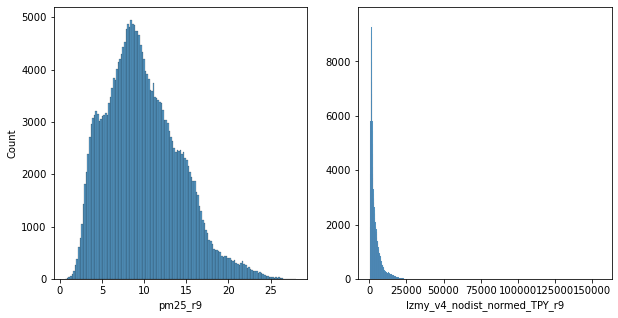

In [29]:
#columns = ['pm25', 'avg_wind_alignment_cosine'] # hardcoded previously but made dynamically
columns = [target_name_s1, predictor_name_s1]


# compute visits by patzip_year_month
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))

for idx, ax in enumerate(axes.flatten()):
    sb.histplot(
            df_all_iv_filtered[columns[idx]],
            ax=ax
        )
    
    if idx in [0]:
        ax.set_ylabel('Count')
    else:
        ax.set_ylabel(' ')

``health outcomes``

In [30]:
print(y_col_names)

['y_visits_all_malignant_cancers', 'y_visits_all_nonblood_malignant_cancers', 'y_visits_blood_diseases', 'y_visits_blood_or_bv_diseases', 'y_visits_blood_vessel_diseases', 'y_visits_cardioresp_cancers', 'y_visits_hematopoietic_cancers', 'y_visits_injuries', 'y_visits_respiratory', 'y_visits_type_1_diabetes']


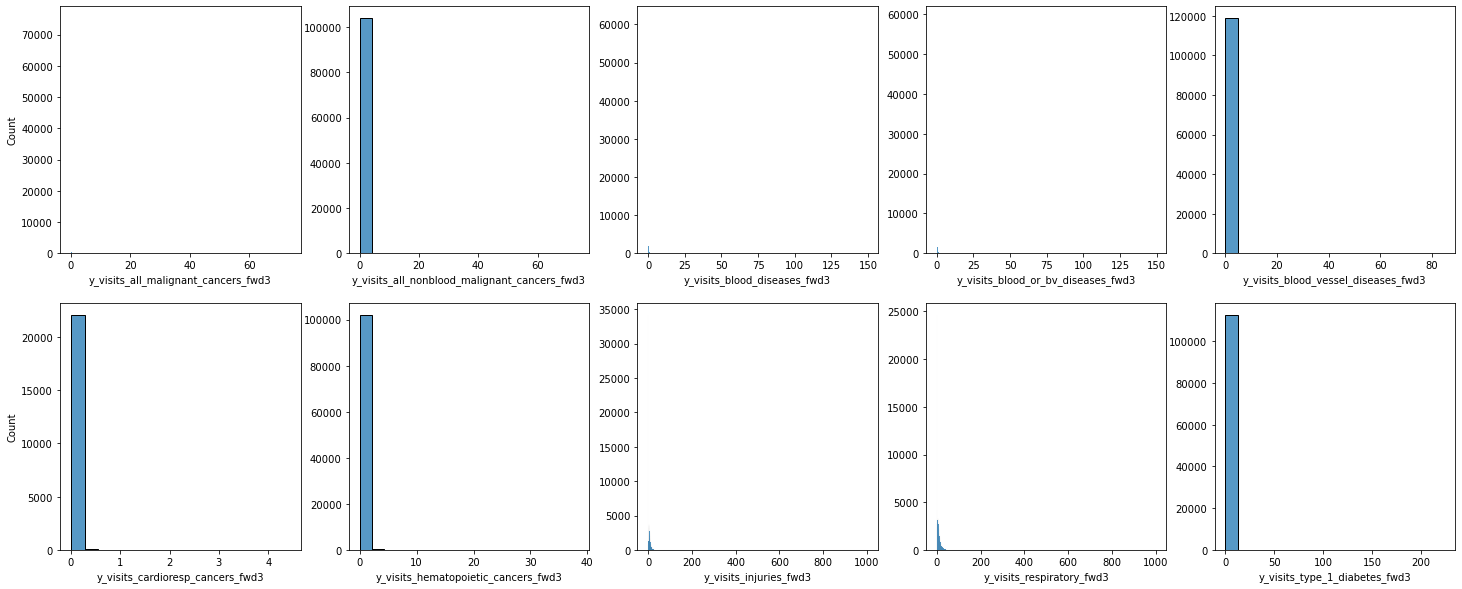

In [31]:
#columns = df_h.columns[1:]
columns = y_col_names_lag

# compute visits by patzip_year_month
fig, axes = plt.subplots(int(len(columns)/5), 5, sharex=False, sharey=False, figsize=(25, int(len(columns))))

for idx, ax in enumerate(axes.flatten()):
    sb.histplot(
            df_all_iv_filtered[columns[idx]],
            ax=ax
        )
    if idx in [0, 5]:
        ax.set_ylabel('Count')
    else:
        ax.set_ylabel(' ')

In [32]:
# columns = y_col_names_lag_diff

# # compute visits by patzip_year_month
# fig, axes = plt.subplots(int(len(columns)/5), 5, sharex=False, sharey=False, figsize=(25, int(len(columns))))

# for idx, ax in enumerate(axes.flatten()):
#     sb.histplot(
#             df_all_iv_filtered[columns[idx]],
#             ax=ax
#         )
#     if idx in [0, 5]:
#         ax.set_ylabel('Count')
#     else:
#         ax.set_ylabel(' ')

---
### Step 7: Analysis - linear modeling

#### 7.1. Check outcome_hat columns
* Make sure that the format contains the lag

In [33]:
# verify names of columns + lag we're going to use
print("y_col_names_lag:\n{}".format(y_col_names_lag))
print("y_col_names_lag_diff:\n{}".format(y_col_names_lag_diff))


y_col_names_lag:
['y_visits_all_malignant_cancers_fwd3', 'y_visits_all_nonblood_malignant_cancers_fwd3', 'y_visits_blood_diseases_fwd3', 'y_visits_blood_or_bv_diseases_fwd3', 'y_visits_blood_vessel_diseases_fwd3', 'y_visits_cardioresp_cancers_fwd3', 'y_visits_hematopoietic_cancers_fwd3', 'y_visits_injuries_fwd3', 'y_visits_respiratory_fwd3', 'y_visits_type_1_diabetes_fwd3']
y_col_names_lag_diff:
['y_visits_all_malignant_cancers_fwd3_diff_r12', 'y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12', 'y_visits_blood_diseases_fwd3_diff_r12', 'y_visits_blood_or_bv_diseases_fwd3_diff_r12', 'y_visits_blood_vessel_diseases_fwd3_diff_r12', 'y_visits_cardioresp_cancers_fwd3_diff_r12', 'y_visits_hematopoietic_cancers_fwd3_diff_r12', 'y_visits_injuries_fwd3_diff_r12', 'y_visits_respiratory_fwd3_diff_r12', 'y_visits_type_1_diabetes_fwd3_diff_r12']


#### 7.2. ``fit ols``

In [34]:
for col in y_col_names_lag:
    fit_ols(df_all_iv_filtered, col, target_name_s1, fixed_effects)

Outcome:  y_visits_all_malignant_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.000632,0.001454,-0.002290,0.003554,0.665621
1,Intercept,0.100952,0.056221,-0.012027,0.213932,0.078719


Outcome:  y_visits_all_nonblood_malignant_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.000115,0.001365,-0.002858,0.002629,0.933451
1,Intercept,0.075238,0.038503,-0.002178,0.152654,0.056532


Outcome:  y_visits_blood_diseases_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.005432,0.002732,-0.000058,0.010922,0.052368
1,Intercept,0.011720,0.054424,-0.097650,0.121090,0.830395


Outcome:  y_visits_blood_or_bv_diseases_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.004735,0.002600,-0.000486,0.009957,0.074495
1,Intercept,-0.007745,0.050169,-0.108513,0.093023,0.877935


Outcome:  y_visits_blood_vessel_diseases_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.001356,0.000697,-0.002757,0.000045,0.057575
1,Intercept,0.014552,0.029941,-0.045649,0.074753,0.629159


Outcome:  y_visits_cardioresp_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.000935,0.000608,-0.002181,0.000311,0.135366
1,Intercept,-0.002803,0.009693,-0.022659,0.017053,0.774568


Outcome:  y_visits_hematopoietic_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.000443,0.001311,-0.002192,0.003078,0.737059
1,Intercept,0.062339,0.053342,-0.044913,0.169591,0.248311


Outcome:  y_visits_injuries_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.041966,0.029481,-0.101152,0.017220,0.160683
1,Intercept,-3.402447,1.044531,-5.499430,-1.305464,0.002003


Outcome:  y_visits_respiratory_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.069444,0.076451,-0.222926,0.084039,0.367971
1,Intercept,-4.376637,1.629142,-7.647275,-1.105999,0.009723


Outcome:  y_visits_type_1_diabetes_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.003193,0.005288,-0.007439,0.013826,0.548763
1,Intercept,-0.281191,0.301910,-0.888223,0.325840,0.356321


In [35]:
for col in y_col_names_lag_diff:
    fit_ols(df_all_iv_filtered, col, target_name_s1, fixed_effects)

Outcome:  y_visits_all_malignant_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.001078,0.002134,-0.003212,0.005367,0.615868
1,Intercept,0.012236,0.039742,-0.067629,0.092101,0.759483


Outcome:  y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.000357,0.001553,-0.002765,0.003478,0.819193
1,Intercept,0.028192,0.019887,-0.011794,0.068179,0.162772


Outcome:  y_visits_blood_diseases_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.000748,0.002381,-0.004037,0.005533,0.754678
1,Intercept,0.112855,0.049661,0.013059,0.212652,0.027477


Outcome:  y_visits_blood_or_bv_diseases_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.000974,0.002526,-0.004100,0.006047,0.701499
1,Intercept,0.057045,0.046843,-0.037041,0.151132,0.229017


Outcome:  y_visits_blood_vessel_diseases_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.000153,0.000787,-0.001430,0.001736,0.846548
1,Intercept,-0.057282,0.034236,-0.126119,0.011555,0.100806


Outcome:  y_visits_cardioresp_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.000658,0.000434,-0.001547,0.000232,0.141012
1,Intercept,-0.002919,0.013362,-0.030290,0.024451,0.828630


Outcome:  y_visits_hematopoietic_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.000703,0.001325,-0.001962,0.003368,0.598077
1,Intercept,-0.011432,0.035474,-0.082758,0.059894,0.748652


Outcome:  y_visits_injuries_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.012006,0.018737,-0.049622,0.025611,0.524564
1,Intercept,-0.839706,0.653292,-2.151243,0.471832,0.204478


Outcome:  y_visits_respiratory_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.073759,0.030578,-0.135146,-0.012371,0.019494
1,Intercept,1.773809,0.630745,0.507536,3.040081,0.006967


Outcome:  y_visits_type_1_diabetes_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.002032,0.002962,-0.003924,0.007988,0.496058
1,Intercept,-0.032344,0.058244,-0.149451,0.084763,0.581255


#### 7.3. ``fit Stage 1``
* The function `fit_1st_stage` is in "Step 3: Define functions" in this notebook; added functionality within that function to output the model object in .pkl form to the directory called models_s1/

In [36]:
df_all_iv_filtered = fit_1st_stage(df_all_iv_filtered, target_name_s1, predictor_name_s1, fixed_effects)


Outcome:  pm25_r9
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,Izmy_v4_nodist_normed_TPY_r9,-0.000119,0.000025,-0.000169,-0.000070,1.056891e-05
1,Intercept,9.436207,1.474332,6.483907,12.388507,3.153043e-08


In [37]:
display(df_all_iv_filtered[[target_name_s1, target_name_s1 + '_hat']])

,pm25_r9,pm25_r9_hat
24,21.916667,19.253049
25,22.851852,19.868156
26,23.625926,19.632135
27,23.583333,19.539759
28,23.418518,18.963502
...,...,...
294892,2.942708,3.204442
294893,3.102431,3.324284
294894,3.113194,3.427717
294895,3.397917,3.540709


#### 7.4. Save Stage 1 dataset (csv + parquet)
Don't worry, Cornelia, these datasets only contain our own features and predictions - we dropped your true health data columns earlier!

In [38]:
# Drops all health-data-related columns before saving
saved_stage1 = df_all_iv_filtered.drop(columns=[i for i in df_all_iv_filtered.columns if 'visit' in i])

In [39]:
# Check that there are no longer any health-data-related columns in the dataset (should return empty list)
[i for i in saved_stage1.columns if 'visit' in i]

[]

In [40]:
# Saving out datasets
saved_stage1_name = "s1_" + notebook_index + "_PREDICTOR_" + predictor_name_s1 +  "_FE_SET_" + str(FE_set_num) + "_TARGETING_" + target_name_s1 + "_LAG" + HO_lag_input
saved_stage1.to_csv(os.path.join(out_dir1, saved_stage1_name + ".csv"))
saved_stage1.to_parquet(os.path.join(out_dir1, saved_stage1_name + ".parquet"))

#### 7.5. Plot counts per pm2.5r# and pm2.5r#_hat

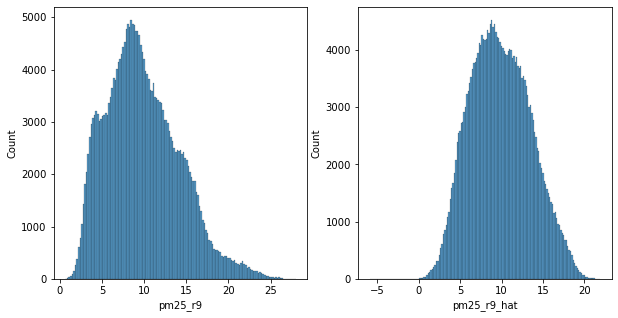

In [41]:
columns = [target_name_s1, target_name_s1+'_hat']

# compute visits by patzip_year_month
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))

for idx, ax in enumerate(axes.flatten()):
    sb.histplot(
            df_all_iv_filtered[columns[idx]],
            ax=ax
        )

#### 7.6. Stage 1 F-test:

Run an F test with our instrument to study the impact on the pm2.5. 

In [42]:
# get data into right model form

y, X_null = dmatrices(f'{target_name_s1} ~ 1', data=df_all_iv_filtered, return_type='dataframe')
y, X_instrument = dmatrices(f'{target_name_s1} ~ 1 + {predictor_name_s1}', data=df_all_iv_filtered, return_type='dataframe')

fit_null = sm.OLS(y, X_null).fit()
fit_instrument = sm.OLS(y, X_instrument).fit()

anovaResults = anova_lm(fit_null, fit_instrument)
anovaResults

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,262449.0,4.934512e+06,0.0,NaN,NaN,NaN
1,262448.0,4.909913e+06,1.0,24599.045777,1314.884877,3.407971e-287


#### 7.7. ``fit 2sls``
* Fits the stage 2 linear regression
* The function `2sls` is in "Step 3: Define functions" in this notebook; added functionality within that function to output the model object in .pkl form to the directory called models_s2/
* Generates dataset after dropping the real health outcomes values (so we're only saving the predicted values)

In [43]:
list_of_stage2_saves = []
saved_stage1_copy = df_all_iv_filtered.drop(columns=[i for i in df_all_iv_filtered.columns if 'visit' in i])

# Merging predicted outcome variables (taken from subsetting the fit_2sls function output dataset) with original dataset (minus visits columns)
for col in y_col_names_lag:
    s2_df = fit_2sls(df_all_iv_filtered, col, target_name_s1+"_hat", fixed_effects)
    
    # subset to have join keys and new columns (e.g. 'y_visits_hematopoietic_cancers_fwd3_hat') only
    outcome_hat = s2_df[['year_month', 'school_zip', col+"_hat"]]
    saved_stage1_copy = pd.merge(saved_stage1_copy, outcome_hat, how='left', left_on=['year_month', 'school_zip'], right_on=['year_month', 'school_zip'])
    rmse_val = np.mean(((df_all_iv_filtered[col] - saved_stage1_copy[col+'_hat'])**2)**.5)
    print('RMSE for {} and {}: {}'.format(col, col+'_hat', rmse_val))



Outliers (over 3 std away) were filtered out, We drop 876 rows.
Outcome:  y_visits_all_malignant_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.010530,0.003644,0.003207,0.017853,0.005729
1,Intercept,-0.151596,0.042269,-0.236539,-0.066654,0.000772


RMSE for y_visits_all_malignant_cancers_fwd3 and y_visits_all_malignant_cancers_fwd3_hat: 0.22335548328771
Outliers (over 3 std away) were filtered out, We drop 556 rows.
Outcome:  y_visits_all_nonblood_malignant_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.005257,0.002946,-0.000666,0.011180,0.080661
1,Intercept,-0.069496,0.029343,-0.128494,-0.010498,0.021938


RMSE for y_visits_all_nonblood_malignant_cancers_fwd3 and y_visits_all_nonblood_malignant_cancers_fwd3_hat: 0.13159437976732488
Outliers (over 3 std away) were filtered out, We drop 726 rows.
Outcome:  y_visits_blood_diseases_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.001767,0.004963,-0.011741,0.008208,0.723436
1,Intercept,0.011052,0.059627,-0.108774,0.130877,0.853724


RMSE for y_visits_blood_diseases_fwd3 and y_visits_blood_diseases_fwd3_hat: 0.351664377646308
Outliers (over 3 std away) were filtered out, We drop 703 rows.
Outcome:  y_visits_blood_or_bv_diseases_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.004066,0.005482,-0.015077,0.006946,0.461789
1,Intercept,0.008365,0.066256,-0.124715,0.141444,0.900042


RMSE for y_visits_blood_or_bv_diseases_fwd3 and y_visits_blood_or_bv_diseases_fwd3_hat: 0.42513745606233894
Outliers (over 3 std away) were filtered out, We drop 320 rows.
Outcome:  y_visits_blood_vessel_diseases_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.003257,0.002777,-0.008841,0.002327,0.246677
1,Intercept,0.014617,0.030222,-0.046148,0.075382,0.630826


RMSE for y_visits_blood_vessel_diseases_fwd3 and y_visits_blood_vessel_diseases_fwd3_hat: 0.11091139888860818
Outliers (over 3 std away) were filtered out, We drop 151 rows.
Outcome:  y_visits_cardioresp_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.000920,0.001335,-0.001815,0.003655,0.496342
1,Intercept,-0.010023,0.016895,-0.044632,0.024585,0.557766


RMSE for y_visits_cardioresp_cancers_fwd3 and y_visits_cardioresp_cancers_fwd3_hat: 0.009617758168795131
Outliers (over 3 std away) were filtered out, We drop 678 rows.
Outcome:  y_visits_hematopoietic_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.002016,0.004508,-0.007048,0.011080,0.656732
1,Intercept,-0.036416,0.049930,-0.136808,0.063975,0.469337


RMSE for y_visits_hematopoietic_cancers_fwd3 and y_visits_hematopoietic_cancers_fwd3_hat: 0.1278812386686845
Outliers (over 3 std away) were filtered out, We drop 723 rows.
Outcome:  y_visits_injuries_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.065703,0.178164,-0.423383,0.291977,0.713821
1,Intercept,-2.622134,1.651717,-5.938094,0.693826,0.118576


RMSE for y_visits_injuries_fwd3 and y_visits_injuries_fwd3_hat: 5.790047363436046
Outliers (over 3 std away) were filtered out, We drop 926 rows.
Outcome:  y_visits_respiratory_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.680098,0.460549,-1.604689,0.244494,0.145902
1,Intercept,2.999056,4.514083,-6.063344,12.061457,0.509441


RMSE for y_visits_respiratory_fwd3 and y_visits_respiratory_fwd3_hat: 8.274358542921094
Outliers (over 3 std away) were filtered out, We drop 123 rows.
Outcome:  y_visits_type_1_diabetes_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.002787,0.003707,-0.004666,0.010239,0.455799
1,Intercept,-0.052646,0.044546,-0.142211,0.036919,0.243091


RMSE for y_visits_type_1_diabetes_fwd3 and y_visits_type_1_diabetes_fwd3_hat: 0.1362708656811485


In [44]:
# Repeat using y_col_names_lag_diff
for col in y_col_names_lag_diff:
    s2_df = fit_2sls(df_all_iv_filtered, col, target_name_s1+"_hat", fixed_effects)
    
    # subset to have join keys and new columns (e.g. 'y_visits_hematopoietic_cancers_fwd3_hat') only
    outcome_hat = s2_df[['year_month', 'school_zip', col, col+"_hat"]]
    saved_stage1_copy = pd.merge(saved_stage1_copy, outcome_hat, how='left', left_on=['year_month', 'school_zip'], right_on=['year_month', 'school_zip'])
    rmse_val = np.mean(((df_all_iv_filtered[col] - saved_stage1_copy[col+'_hat'])**2)**.5)
    print('RMSE for {} and {}: {}'.format(col, col+'_hat', rmse_val))

Outliers (over 3 std away) were filtered out, We drop 974 rows.
Outcome:  y_visits_all_malignant_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.003984,0.002176,-0.000388,0.008356,0.073127
1,Intercept,-0.041460,0.026132,-0.093974,0.011053,0.119036


RMSE for y_visits_all_malignant_cancers_fwd3_diff_r12 and y_visits_all_malignant_cancers_fwd3_diff_r12_hat: 0.2584213272073817
Outliers (over 3 std away) were filtered out, We drop 721 rows.
Outcome:  y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.001949,0.001929,-0.001929,0.005827,0.317278
1,Intercept,-0.016526,0.018936,-0.054599,0.021547,0.387139


RMSE for y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12 and y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12_hat: 0.16406733385542444
Outliers (over 3 std away) were filtered out, We drop 1069 rows.
Outcome:  y_visits_blood_diseases_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.005337,0.002104,-0.009566,-0.001108,0.014452
1,Intercept,0.160079,0.037643,0.084433,0.235725,0.000095


RMSE for y_visits_blood_diseases_fwd3_diff_r12 and y_visits_blood_diseases_fwd3_diff_r12_hat: 0.3460075429534517
Outliers (over 3 std away) were filtered out, We drop 1008 rows.
Outcome:  y_visits_blood_or_bv_diseases_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.002680,0.002304,-0.007309,0.001948,0.250237
1,Intercept,0.103171,0.029809,0.043298,0.163044,0.001110


RMSE for y_visits_blood_or_bv_diseases_fwd3_diff_r12 and y_visits_blood_or_bv_diseases_fwd3_diff_r12_hat: 0.4085880460161992
Outliers (over 3 std away) were filtered out, We drop 328 rows.
Outcome:  y_visits_blood_vessel_diseases_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.000492,0.001324,-0.002170,0.003153,0.711853
1,Intercept,-0.025460,0.020468,-0.066614,0.015693,0.219572


RMSE for y_visits_blood_vessel_diseases_fwd3_diff_r12 and y_visits_blood_vessel_diseases_fwd3_diff_r12_hat: 0.1283549250026971
Outliers (over 3 std away) were filtered out, We drop 213 rows.
Outcome:  y_visits_cardioresp_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.001581,0.000991,-0.000449,0.003611,0.121882
1,Intercept,-0.024063,0.011357,-0.047328,-0.000799,0.043116


RMSE for y_visits_cardioresp_cancers_fwd3_diff_r12 and y_visits_cardioresp_cancers_fwd3_diff_r12_hat: 0.012493476520161726
Outliers (over 3 std away) were filtered out, We drop 859 rows.
Outcome:  y_visits_hematopoietic_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.002513,0.001943,-0.001394,0.006420,0.202100
1,Intercept,-0.032500,0.022380,-0.077497,0.012497,0.152943


RMSE for y_visits_hematopoietic_cancers_fwd3_diff_r12 and y_visits_hematopoietic_cancers_fwd3_diff_r12_hat: 0.1396299856546964
Outliers (over 3 std away) were filtered out, We drop 781 rows.
Outcome:  y_visits_injuries_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.000402,0.051079,-0.102948,0.102144,0.993753
1,Intercept,-0.451013,0.538081,-1.531257,0.629231,0.405837


RMSE for y_visits_injuries_fwd3_diff_r12 and y_visits_injuries_fwd3_diff_r12_hat: 2.9343203609424187
Outliers (over 3 std away) were filtered out, We drop 789 rows.
Outcome:  y_visits_respiratory_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.276145,0.089055,-0.454930,-0.097360,0.00314
1,Intercept,4.021781,0.995506,2.023219,6.020344,0.00018


RMSE for y_visits_respiratory_fwd3_diff_r12 and y_visits_respiratory_fwd3_diff_r12_hat: 4.232400095108395
Outliers (over 3 std away) were filtered out, We drop 96 rows.
Outcome:  y_visits_type_1_diabetes_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.001758,0.001913,-0.002088,0.005604,0.362794
1,Intercept,-0.009509,0.024448,-0.058664,0.039647,0.699046


RMSE for y_visits_type_1_diabetes_fwd3_diff_r12 and y_visits_type_1_diabetes_fwd3_diff_r12_hat: 0.17155864260033807


#### 7.8. Save Stage 2 dataset
* Contains: all pm2.5r#, pm2.5r#_hat, outcome_hats, all instruments

In [45]:
# saves stage 2 datasets (minus any visits columns) as csv and parquet

s2_dataset_out_name = "s2_" + notebook_index + "_INSTRUMENT_" + predictor_name_s1 + "_FE_SET_" + str(FE_set_num) + "_TARGETING_" + "all_outcomes" + "_LAG" + HO_lag_input
saved_stage1_copy.to_csv(os.path.join(out_dir2, s2_dataset_out_name + ".csv"))
saved_stage1_copy.to_parquet(os.path.join(out_dir2, s2_dataset_out_name + ".parquet"))

#### 7.9. Generate dataset with name of the notebook, the stage 1 and stage 2 model and corresponding fixed effects (csv)
* Generates a csv that associates an instrument-plus-fixed-effects combo with the filenames of S1 and S2 datasets that we wrote out (doesn't include any columns with real outcome/visit data)

In [46]:
csv_name = 'fixed_effects_' + notebook_index + '.csv'
FE_df_data = [[notebook_index, predictor, fixed_effects, saved_stage1_name+'.csv', s2_dataset_out_name+'.csv']]
FE_df = pd.DataFrame(data=FE_df_data, columns=['notebook_idx', 'instrument_name', 'fixed_effects_list', 's1_filename', 's2_filename'])
display(FE_df)

,notebook_idx,instrument_name,fixed_effects_list,s1_filename,s2_filename
0,diff06_no_outliers_fn_F,Izmy_v4_nodist_normed_TPY,~ county + month + year_trend * C(county_mont...,s1_diff06_no_outliers_fn_F_PREDICTOR_Izmy_v4_n...,s2_diff06_no_outliers_fn_F_INSTRUMENT_Izmy_v4_...


In [47]:
# Write out to csv
FE_df.to_csv(os.path.join(out_dir3, csv_name))